# Successors Experimentation
Attempting to figure out how to use GerryChain classes/methods to find successors of a partition. 

In [1]:
# Slow imports
import descartes
import geopandas as gpd
import networkx as nx
import numpy as np
import pandas as pd


In [3]:
# Other imports
import csv
import math
import matplotlib.pyplot as plt
import os
import random
import timeit

from gerrychain import Graph, Partition
from gerrychain.updaters import cut_edges, Tally

from partitionnode import PartitionNode
from pathsearch import run_search

import utils

In [4]:
# Load GOP/Dem maps for Wisconsin
gop_map, dem_map, gdf = utils.get_sample_wi_maps()

In [12]:
# Create modified GOP maps with set number of single-unit swaps
gop_map_30_flips = utils.make_random_flips(gop_map, 30)
gop_map_50_flips = utils.make_random_flips(gop_map, 50)
gop_map_70_flips = utils.make_random_flips(gop_map, 70)
gop_map_100_flips = utils.make_random_flips(gop_map, 100)
gop_map_150_flips = utils.make_random_flips(gop_map, 150)
gop_map_500_flips = utils.make_random_flips(gop_map, 500)

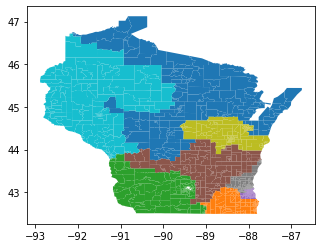

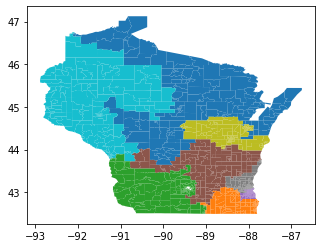

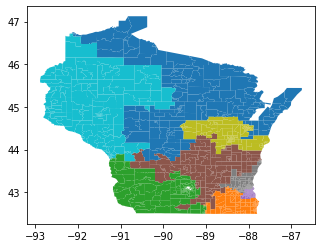

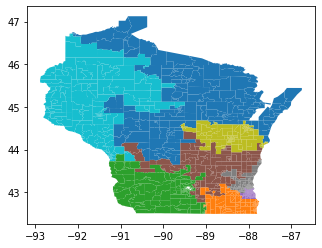

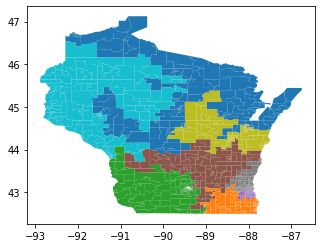

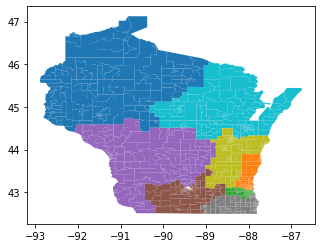

In [13]:
# View gop_map and gop_map_modified
gop_map.plot();
gop_map_30_flips.plot();
gop_map_70_flips.plot();
gop_map_150_flips.plot();
gop_map_500_flips.plot();
dem_map.plot();

True
{'1': 721865, '5': 718573, '8': 679219, '7': 733155, '3': 710158, '2': 705378, '6': 714911, '4': 703727}


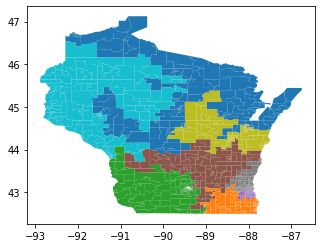

In [17]:
# Check contiguity
from gerrychain.constraints import contiguous

print(contiguous(gop_map_500_flips))
print(gop_map_500_flips['population'])
gop_map_500_flips.plot();

## Try running chain with ReCom

In [27]:
# Set up the chain
from gerrychain import proposals, constraints, updaters, accept, MarkovChain
from gerrychain.proposals import recom
from functools import partial

ideal_population = sum(gop_map["population"].values()) / len(gop_map)

proposal = partial(recom, 
                   pop_col="population",
                   pop_target=ideal_population,
                   epsilon=0.05,
                   node_repeats=2
                  )

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(gop_map["cut_edges"])
)
pop_constraint = constraints.within_percent_of_ideal_population(gop_map, 0.05)

chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=gop_map,
    total_steps=6
)

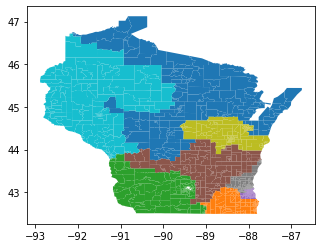

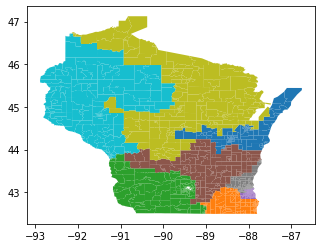

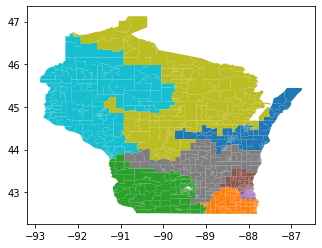

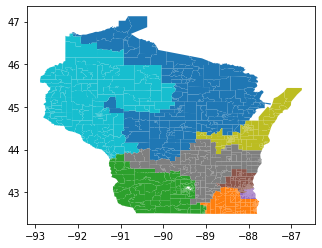

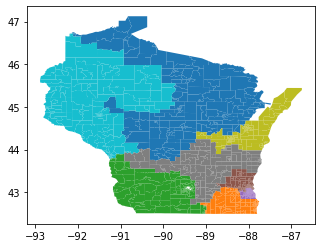

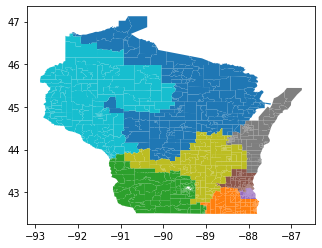

In [29]:
# Run the chain
chain_maps = []
for partition in chain:
    chain_maps.append(partition)
    partition.plot();

In [37]:
# Find path between gop_map and one ReCom step later
root = PartitionNode(
        partition=gop_map,
        target=chain_maps[1],
        map_gdf=gdf,
        compat_property='population')

path, efficiency_gap, negative_variance, mean_median_gap = run_search(root)
print('Efficiency gap:\n{0:.4f} to {1:.4f}'.format(efficiency_gap[0], efficiency_gap[-1]))
print('Negative variance:\n{0:.4f} to {1:.4f}'.format(negative_variance[0], negative_variance[-1]))
print('Mean median gap:\n{0:.4f} to {1:.4f}'.format(mean_median_gap[0], mean_median_gap[-1]))

KeyboardInterrupt: 

In [33]:
# Find path between gop_map and gop_map_150_flips
root = PartitionNode(
        partition=gop_map,
        target=gop_map_150_flips,
        map_gdf=gdf,
        compat_property='population')

path, efficiency_gap, negative_variance, mean_median_gap = run_search(root)
print('Efficiency gap:\n{0:.4f} to {1:.4f}'.format(efficiency_gap[0], efficiency_gap[-1]))
print('Negative variance:\n{0:.4f} to {1:.4f}'.format(negative_variance[0], negative_variance[-1]))
print('Mean median gap:\n{0:.4f} to {1:.4f}'.format(mean_median_gap[0], mean_median_gap[-1]))

KeyboardInterrupt: 

In [11]:
# Find path between gop_map and gop_map_70_flips
root = PartitionNode(
        partition=gop_map,
        target=gop_map_70_flips,
        map_gdf=gdf,
        compat_property='population')

path, efficiency_gap, negative_variance, mean_median_gap = run_search(root)
print('Efficiency gap:\n{0:.4f} to {1:.4f}'.format(efficiency_gap[0], efficiency_gap[-1]))
print('Negative variance:\n{0:.4f} to {1:.4f}'.format(negative_variance[0], negative_variance[-1]))
print('Mean median gap:\n{0:.4f} to {1:.4f}'.format(mean_median_gap[0], mean_median_gap[-1]))

Elapsed time: 25.676 s
Time generating successors: 29.820 s
Path found.
	Path length: 66 maps (including start and end)
	Value (sum of compatibility differences): 0.06855
	Initial incompatibility: 0.06855
	Visited nodes: 24531
[0.4524684313370123, 0.4595708143830427, 0.66693161266802, 0.6521919812660203, 0.4654098949390842, 0.4761363396776953, 0.4640121163086797, 0.4764240990736557]
[0.4538300827927436, 0.4643926565882455, 0.6648788533675675, 0.6510600250040784, 0.46802310566881206, 0.46373469542811707, 0.4627769101891632, 0.47624505474281403]
Efficiency gap:
0.2591 to 0.2531
Negative variance:
-0.0071 to -0.0070
Mean median gap:
0.0434 to 0.0469


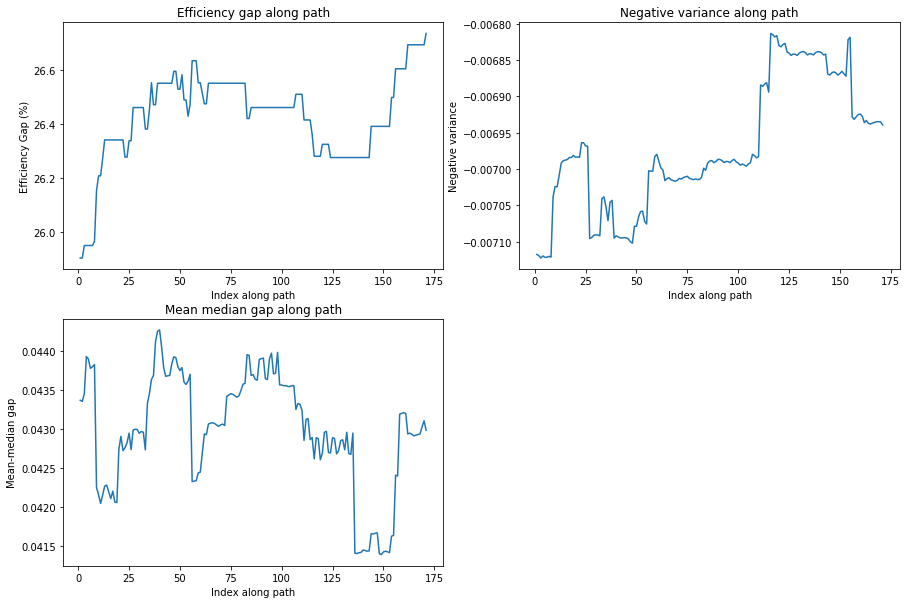

In [19]:
# Visualize path
x = range(1, len(path) + 1)
fig, axs = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(15)
axs[0, 0].plot(x, efficiency_gap * 100)
axs[0, 0].set_title('Efficiency gap along path')
axs[0, 0].set_xlabel('Index along path')
axs[0, 0].set_ylabel('Efficiency Gap (%)')

axs[0, 1].plot(x, negative_variance)
axs[0, 1].set_title('Negative variance along path')
axs[0, 1].set_xlabel('Index along path')
axs[0, 1].set_ylabel('Negative variance')

axs[1, 0].plot(x, mean_median_gap)
axs[1, 0].set_title('Mean median gap along path')
axs[1, 0].set_xlabel('Index along path')
axs[1, 0].set_ylabel('Mean-median gap');
axs[1, 1].set_visible(False)

## Older code/scratchwork

Republican Map:
District 1 population: 681581
District 2 population: 691382
District 3 population: 737619
District 4 population: 706056
District 5 population: 735011
District 6 population: 678739
District 7 population: 736705
District 8 population: 719893

Democratic Map:
District 1 population: 737728
District 2 population: 737797
District 3 population: 712864
District 4 population: 702091
District 5 population: 711837
District 6 population: 677011
District 7 population: 680545
District 8 population: 727113



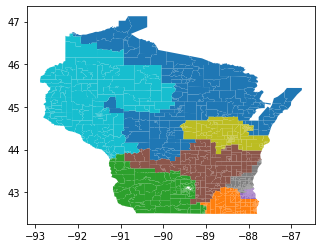

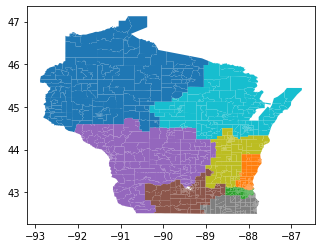

In [11]:
# Get rough sketch of both maps
for index, district_map in enumerate([gop_map, dem_map]):
    print('Republican Map:' if index == 0 else 'Democratic Map:')
    for i in range(1, len(gop_map.parts) + 1):
        print('District', i, 'population:', district_map['population'][str(i)])
    print()
    district_map.plot()

In [24]:
self_parts = gop_map.parts
other_parts = gop_map_modified.parts

for part in self_parts:
    part_units = self_parts[part]
    print(part, len(part_units))
    
print()
    
for part in other_parts:
    part_units = other_parts[part]
    print(part, len(part_units))
    
count_match = 0
for self_part in self_parts:
    for other_part in other_parts:
        int_set = self_parts[self_part].intersection(other_parts[other_part])
        if int_set:
            print('There are {0} shared units between {1} in self and {2} in other.'.format(len(int_set), self_part, other_part))
        if self_parts[self_part] == other_parts[other_part]:
            count_match += 1

print('Matches:', count_match)

1 181
5 165
8 165
7 167
3 173
2 150
6 171
4 220

1 180
5 165
8 166
7 167
3 173
2 152
6 171
4 218
There are 180 shared units between 1 in self and 1 in other.
There are 1 shared units between 1 in self and 8 in other.
There are 165 shared units between 5 in self and 5 in other.
There are 165 shared units between 8 in self and 8 in other.
There are 167 shared units between 7 in self and 7 in other.
There are 173 shared units between 3 in self and 3 in other.
There are 150 shared units between 2 in self and 2 in other.
There are 171 shared units between 6 in self and 6 in other.
There are 2 shared units between 4 in self and 2 in other.
There are 218 shared units between 4 in self and 4 in other.
Matches: 4


In [8]:
cut_edge = random.choice(list(init_partition.cut_edges))
print(cut_edge)

('55133203500', '55133203703')


In [10]:
# Generate list of feasible flips (one-swaps) to get successors.
# Based on propose_random_flip(): https://github.com/mggg/GerryChain/blob/master/gerrychain/proposals/proposals.py
partition = init_partition;
flips = []
for edge in partition['cut_edges']:
    for index in [0, 1]:
        flipped_node, other_node = edge[index], edge[1 - index]
        flips.append({flipped_node: partition.assignment[other_node]})        

In [12]:
all_units = set()
for part in partition.parts:
    if part > 0:
        all_units = all_units.union(partition.parts[part])

In [16]:
units_subset = init_partition.parts[3]
units_subset_ser = pd.Series(np.array(list(units_subset)), name='GEOID')
units_subset_ser
gdf_units = gdf.reset_index()
gdf_units['GEOID'] = gdf_units['GEOID']
gdf_units['GEOID']
# units_subset_ser
total_pop = gdf_units.merge(units_subset_ser, on='GEOID')['population'].sum()

In [17]:
total_pop

712864

In [18]:
init_partition

<Partition [8 parts]>

In [19]:
len(init_partition.parts)

8

In [20]:
gdf_reset = gdf.reset_index()
all_units = set(gdf_reset['GEOID'])

In [21]:
gdf.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry',
       'population'],
      dtype='object')

In [26]:
map_gdf[0].columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry',
       'population', 'district'],
      dtype='object')

In [34]:
df = pop_df.reset_index()

In [38]:
all_units = set(df['GEOID'])

In [43]:
init_partition.graph.nodes['55009002002']

{'boundary_node': False,
 'area': 3600128.9366311287,
 'STATEFP': '55',
 'COUNTYFP': '009',
 'TRACTCE': '002002',
 'NAME': '20.02',
 'NAMELSAD': 'Census Tract 20.02',
 'MTFCC': 'G5020',
 'FUNCSTAT': 'S',
 'ALAND': 3602498,
 'AWATER': 0,
 'INTPTLAT': '+44.4804525',
 'INTPTLON': '-087.9563805',
 'geometry': <shapely.geometry.polygon.Polygon at 0x234f0ca6448>,
 'population': 5157,
 'district': 8}